# Functions to be used for the task

Purpose of this notebook is to create functions that will be used later. These are sequential functions.

In [1]:
import pandas as pd
import folium

df = pd.read_csv('bike_rent/202101-divvy-tripdata.csv')
df = df.sample(1000)

In [2]:
# DataFrame -> DataFrame

# 1. filter and prepare data
#     - remove NA
#     - remove long durations 
#     - leave only from known station to station
#     - calculate the actual duration (time end - time start)

def filter_and_prepare_data(df):
    # Remove rows with NA in start_station_id or end_station_id
    df = df.dropna(subset=['start_station_id', 'end_station_id']).reset_index(drop=True)
    
    # Convert the 'started_at' and 'ended_at' columns to datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    
    # Calculate duration in seconds
    df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()
    
    # Filter by duration, keeping trips from 1 minute to 1 hour
    df = df[(df['duration'] >= 60) & (df['duration'] <= 3600)].reset_index(drop=True)
    
    return df

print(f"Initial number of rows: {len(df)}")
df = filter_and_prepare_data(df)
print(f"Number of rows after filtering: {len(df)}")

Initial number of rows: 1000
Number of rows after filtering: 835


In [3]:
# DataFrame -> dict

# 2. check stats
#     - distribution per type, membership
#     - count each day total trips

def get_stats(df):
    bike_counts = df.rideable_type.value_counts().to_dict()
    member_counts = df.member_casual.value_counts().to_dict()
    daily_counts = df['started_at'].dt.date.value_counts().sort_index().to_dict()

    stats = {
        'bike_counts': bike_counts,
        'member_counts': member_counts,
        'daily_counts': daily_counts
    }

    return stats

def join_stats(stats):
    """
    Join multiple stats dictionaries into one.
    """
    joined_stats = {
        'bike_counts': {},
        'member_counts': {},
        'daily_counts': {}
    }

    for stat in stats:
        for key in joined_stats.keys():
            for k, v in stat[key].items():
                if k in joined_stats[key]:
                    joined_stats[key][k] += v
                else:
                    joined_stats[key][k] = v

    return joined_stats

    
# test join stats
stat1 = get_stats(df.sample(10))
stat2 = get_stats(df.sample(10))
joined_stat = join_stats([stat1, stat2])

In [4]:
# DataFrame, station_dict -> station_dict

# 3. preprocess stations:
#     - for each station, find the center
#     - create a dict with station_id as key and (lat, lon) as value

def get_station_coordinates(df, station_coords):

    # Extract start and end station coordinates to one DataFrame
    start_coords = df[['start_station_id', 'start_lat', 'start_lng']]
    end_coords = df[['end_station_id', 'end_lat', 'end_lng']]
    start_coords = start_coords.rename(columns={
        'start_station_id': 'station_id',
        'start_lat': 'latitude',
        'start_lng': 'longitude'
    })
    end_coords = end_coords.rename(columns={
        'end_station_id': 'station_id',
        'end_lat': 'latitude',
        'end_lng': 'longitude'
    })
    all_coords = pd.concat([start_coords, end_coords])

    # Remove existing stations from the DataFrame
    all_coords = all_coords[~ all_coords.station_id.isin(station_coords.keys())]
    
    # Calculate the median coordinates for each station
    all_coords = all_coords.groupby('station_id').median().reset_index()
    new_station_coords = all_coords.set_index('station_id').T.to_dict('list')
    
    # Update then dict and return
    return station_coords | new_station_coords

station_coords = {}
station_coords = get_station_coordinates(df.sample(100), station_coords)
print(len(station_coords))
station_coords = get_station_coordinates(df, station_coords)
print(len(station_coords))

147
395


In [5]:
# 4. calculate the shortest routes' durations
#     - go through all trips
#     - save the duration (from start_id, to end_id), reuse it (lookup table)
#     - append the shortest durations

import networkx as nx
import osmnx as ox

MEAN_LAT = 41.90234770710154
MEAN_LNG = -87.64440345010253


def load_graph():
    # Create a graph from the center of the data
    G = ox.graph_from_point((MEAN_LAT, MEAN_LNG), dist=5000, network_type="bike")

    # Optionally, save and then load the graph
    # ox.save_graphml(G, "my_graph.graphml")
    # G = ox.load_graphml("my_graph.graphml")

    # assign speeds constant speed to all edges
    nx.set_edge_attributes(G, values=10, name="speed_kph")

    # convert length+speed → seconds
    G = ox.add_edge_travel_times(G)

    return G

G = load_graph()


In [8]:
def calculate_fastest_travel_time(G, start_lat, start_lng, end_lat, end_lng):
    # In the graph, get the nodes closest to the points
    origin_node = ox.nearest_nodes(G, Y=start_lat, X=start_lng)
    destination_node = ox.nearest_nodes(G, Y=end_lat, X=end_lng)

    # compute travel time in seconds
    try:
        travel_time_in_seconds = nx.shortest_path_length(G, origin_node, destination_node, weight='travel_time')
    except nx.NetworkXNoPath:
        print(f"No path found from ({start_lat}, {start_lng}) to ({end_lat}, {end_lng})")
        return -1
    
    return travel_time_in_seconds


# for the sake of an example
test = df.iloc[0]
start_lat = test.start_lat
start_lng = test.start_lng
end_lat = test.end_lat
end_lng = test.end_lng

print(f"Fastest travel time from ({start_lat}, {start_lng}) to ({end_lat}, {end_lng}): "
        f"{calculate_fastest_travel_time(G, start_lat, start_lng, end_lat, end_lng)} seconds")

Fastest travel time from (41.895501, -87.682017) to (41.871262, -87.673688): 1179.236831503033 seconds


In [9]:
from tqdm.notebook import tqdm

tbar = tqdm(total=len(df), desc="Calculating durations", unit="trip")

distance_cache = {} # (start_id, end_id) -> duration
station_coords = station_coords # (station_id -> (lat, lon))

durations = []
for index, row in df.iterrows():
    tbar.update(1)
    start_id = row['start_station_id']
    end_id = row['end_station_id']
    
    # Check if the duration is already cached
    if (start_id, end_id) in distance_cache:
        duration = distance_cache[(start_id, end_id)]
    else:
        start_lat, start_lng = station_coords[start_id]
        end_lat, end_lng = station_coords[end_id]
        
        # Calculate the travel time
        duration = calculate_fastest_travel_time(G, start_lat, start_lng, end_lat, end_lng)
        
        # Cache the result
        distance_cache[(start_id, end_id)] = duration
    
    durations.append(duration)

Calculating durations:   0%|          | 0/835 [00:00<?, ?trip/s]

No path found from (41.884241, -87.629634) to (41.881892, -87.648789)
No path found from (41.884241, -87.629634) to (41.888243, -87.63639)
No path found from (41.912222416666665, -87.63483725) to (41.89257, -87.614492)
No path found from (41.884241, -87.629634) to (41.870816, -87.631246)
No path found from (41.795212, -87.580715) to (41.89766, -87.62351)
No path found from (41.884241, -87.629634) to (41.876268, -87.629155)
No path found from (41.884241, -87.629634) to (41.90298533333333, -87.63423633333333)
No path found from (41.87811603010527, -87.63983845710754) to (41.886024, -87.624117)
No path found from (41.87811603010527, -87.63983845710754) to (41.8985866514, -87.6219152258)
No path found from (41.884241, -87.629634) to (41.94018, -87.65304)
No path found from (41.890173, -87.626185) to (41.89766, -87.62351)


<Axes: >

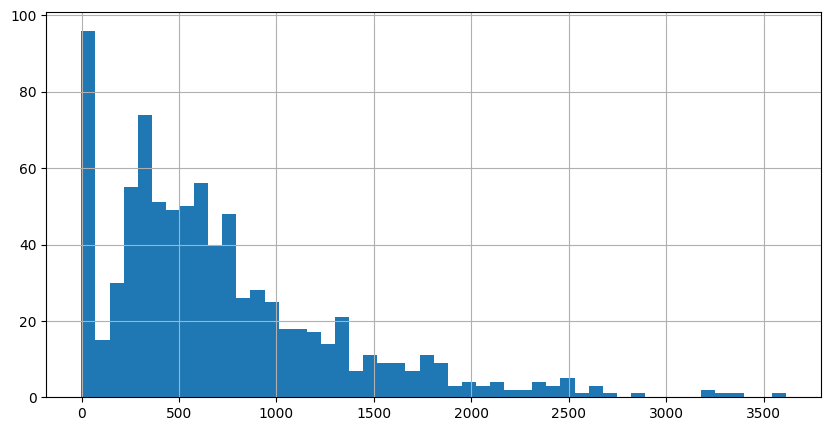

In [15]:
df["fastest_duration"] = durations
df["fastest_duration"].hist(bins=50, figsize=(10, 5))

In [17]:
len(df)

835

In [19]:
# 5. filter 
#     - remove routes which took much longer than the shortest possible duration (20% longer)

def filter_slow_riders(df, threshold=1.1):
    """
    Filter out trips where the actual duration is more than `threshold` times the fastest duration.
    This automatically drops -1 durations as well.
    """
    df = df[df['duration'] <= df['fastest_duration'] * threshold].reset_index(drop=True)
    return df

df = filter_slow_riders(df)
print(f"Number of rows after filtering slow riders: {len(df)}")

Number of rows after filtering slow riders: 559


In [20]:
# 6. check stats
#     - distribution per type, membership
#     - count each day total trips
#     - compare to original stats

fast_stats = get_stats(df)

In [22]:
import matplotlib.pyplot as plt

# Histogram of daily counts

fast_stats["daily_counts"]

AttributeError: 'dict' object has no attribute 'hist'

In [ ]:

# 7. plot the routes
#     - group by start and end station
#     - the more frequent the route is, the bigger the line